# Sentiment Variance Analysis 

- This notebook is used for the analysis of variance in review sentiment across different ratings. 
- `vaderSentiment` and `DistilBERT` were used for sentiment scoring.

## Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification

SEED = 9

## Load normalised and cleaned data from csv file

In [2]:
df_review_normalised = pd.read_csv("review_camera_normalised.csv")
df_review_normalised = df_review_normalised.dropna()

C:\Users\mikec\AppData\Local\Temp\ipykernel_15240\1631210238.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_review_normalised = pd.read_csv("review_camera_normalised.csv")


In [3]:
IS: pd.DataFrame
OS: pd.DataFrame
IS, OOS = train_test_split(
    df_review_normalised,
    test_size=0.2,
    random_state=SEED,
)

In [4]:
df_review_normalised_subset = IS.sample(
    # n=int(5e4),
    frac=1.0,
    random_state=SEED,
)
df_review_normalised_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211872 entries, 1104540 to 920118
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     211872 non-null  float64
 1   verified    211872 non-null  bool   
 2   reviewTime  211872 non-null  object 
 3   asin        211872 non-null  object 
 4   reviewText  211872 non-null  object 
 5   vote        211872 non-null  object 
 6   image       211872 non-null  bool   
 7   Year        211872 non-null  int64  
 8   price       211872 non-null  float64
 9   main_cat    211872 non-null  object 
dtypes: bool(2), float64(2), int64(1), object(5)
memory usage: 15.0+ MB


In [5]:
df_review_normalised_subset

,overall,verified,reviewTime,asin,reviewText,vote,image,Year,price,main_cat
1104540,5.0,True,2014-01-24,B00CIUZF2I,rate star search new charger camera forever st...,2,False,2014,4.48,Camera & Photo
464797,5.0,True,2015-11-05,B001ZTCYI6,work push pull lens twist focus lens work,2,False,2015,44.95,Camera & Photo
1373894,5.0,True,2015-11-28,B00K919SHG,especially want approve list product good choi...,2,False,2015,11.95,Camera & Photo
4928,5.0,False,2000-12-30,B00004TQ0T,love camera want camera good family photo use ...,10,False,2000,15.99,Camera & Photo
1107118,5.0,True,2018-01-07,B00CMKOSDQ,love fit perfect little room battery extra sd ...,2,False,2018,12.79,Camera & Photo
...,...,...,...,...,...,...,...,...,...,...
1818457,5.0,True,2016-09-21,B018SRPTUC,buy birthday gift good friend fall love tell r...,3.0,True,2016,7.78,Camera & Photo
247869,5.0,True,2007-06-01,B000ME8R22,purchase battery spare size come recorder batt...,25,False,2007,39.95,Camera & Photo
787964,5.0,True,2013-08-15,B005IHAICK,time upgrade realize bad spoil absolutely fant...,2,False,2013,455.00,Camera & Photo
972839,5.0,False,2013-10-25,B0099XGZXA,got camera frame start freelance work occasion...,2,False,2013,565.00,Camera & Photo


In [6]:
df_only_one_and_five = df_review_normalised_subset[
    (df_review_normalised_subset["overall"] == 1.0)
    | (df_review_normalised_subset["overall"] == 5.0)
]
df_only_one_and_five

,overall,verified,reviewTime,asin,reviewText,vote,image,Year,price,main_cat
1104540,5.0,True,2014-01-24,B00CIUZF2I,rate star search new charger camera forever st...,2,False,2014,4.48,Camera & Photo
464797,5.0,True,2015-11-05,B001ZTCYI6,work push pull lens twist focus lens work,2,False,2015,44.95,Camera & Photo
1373894,5.0,True,2015-11-28,B00K919SHG,especially want approve list product good choi...,2,False,2015,11.95,Camera & Photo
4928,5.0,False,2000-12-30,B00004TQ0T,love camera want camera good family photo use ...,10,False,2000,15.99,Camera & Photo
1107118,5.0,True,2018-01-07,B00CMKOSDQ,love fit perfect little room battery extra sd ...,2,False,2018,12.79,Camera & Photo
...,...,...,...,...,...,...,...,...,...,...
1825333,1.0,True,2016-08-18,B019GB0GUW,purchase use baby monitor volume low hear baby...,2,False,2016,4.06,Camera & Photo
1818457,5.0,True,2016-09-21,B018SRPTUC,buy birthday gift good friend fall love tell r...,3.0,True,2016,7.78,Camera & Photo
247869,5.0,True,2007-06-01,B000ME8R22,purchase battery spare size come recorder batt...,25,False,2007,39.95,Camera & Photo
787964,5.0,True,2013-08-15,B005IHAICK,time upgrade realize bad spoil absolutely fant...,2,False,2013,455.00,Camera & Photo


<Axes: title={'center': 'Number of reviews with score 1 or 5'}, xlabel='overall'>

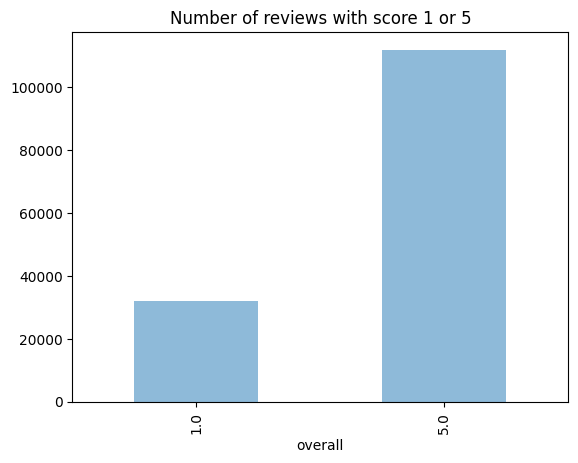

In [7]:
df_only_one_and_five["overall"].value_counts().sort_index().plot.bar(alpha=0.5, title="Number of reviews with score 1 or 5")

# Vader Sentiment Approach

In [15]:
analyser = SentimentIntensityAnalyzer()

In [16]:
results = []
for i in range(1, 6):
    reviewText_given_score = IS[(IS["overall"] == float(i))]["reviewText"].tolist()
    for review in reviewText_given_score:
        results.append([i, review, analyser.polarity_scores(review)["compound"]])
results = pd.DataFrame(results, columns=["Score", "review", "polarity"])
results

,Score,review,polarity
0,1,support light work find electrician use bad,-0.2023
1,1,send seek incredibly slow shutter speed select...,-0.9536
2,1,returned work drone tell work pro connection,0.0000
3,1,r advertised shipping label state ship r actua...,0.5267
4,1,software make time consume use camera own doze...,0.0000
...,...,...,...
211867,5,work advertised simplifie align process like n...,0.3612
211868,5,div block section spacing small spacing mini v...,0.8910
211869,5,great little photo studio use photograph perso...,0.9477
211870,5,happy purchase great camera have hard time jus...,0.9866


In [17]:
results.to_csv("vader-result.csv")

In [18]:
results = pd.read_csv("vader-result.csv", index_col=0)

The review of highest sentiment score among Score 1.

In [19]:
results[results["Score"] == 1].sort_values("polarity", ascending=False).iloc[0]["review"]

'starter buy camera cannon pay broke render useless take photo photo turn turn camera repair place want charge fix ha buy olympus stylus bad camera own review profile look review send buy camera love camera pro size small small fit hand right camera way bulky shutter speed great love have wait forever multiple shot row like camera choose model verses new need extra mode professional want photo kid battery last take photo day kid take photo charge battery love option multi delete convenient take photo row good photo kid eye open make goofy face shutter speed great time take model favorite color red nuff say weight perfect heavy light flash work great long distant shot like placement flash button zoom easy navigate user friendly look owner manual auto mode pretty good love mode play alot great design function firework come photograph flash good room improvement photo come little dark object away dark room record video zoom start close child face well hope stay able zoom microphone right 

The review of lowest sentiment score among Score 1.

In [20]:
results[results["Score"] == 1].sort_values("polarity", ascending=True).iloc[0]["review"]

'allow product sell accident protection term condition point type accident cover find know exact time canon lens getting scratch accident protection plan cover know date happen photograph take damage occur know scratch happen nope product cover damage lens actually terms condition take product cover cover purchase read fine print avoid rip product cover reasonable person assume cover wh n o t c ove d e ral e xc l ion s related applicable covered service contract cover failure damage loss result claim purchase confirm contract purchase receipt b pre existing condition know pre existing condition refer condition reasonable mechanical electrical probability relate mechanical fitness product contract purchase c merchandise intend use heavy commercial industrial application operation non residential use include rental business educational institutional commercial upgrade option purchase d claim service replacement cover product prior authorize administrator e claim relate cosmetic damage me

In [21]:
aggregated = (
    results.groupby(['Score'])["polarity"].agg([('polarity mean', 'mean'), ('polarity std', 'std')])
    .reset_index()                                          # make groupers into columns
)
aggregated

,Score,polarity mean,polarity std
0,1,0.066742,0.592423
1,2,0.318484,0.582198
2,3,0.518386,0.509742
3,4,0.714852,0.386369
4,5,0.762532,0.327844


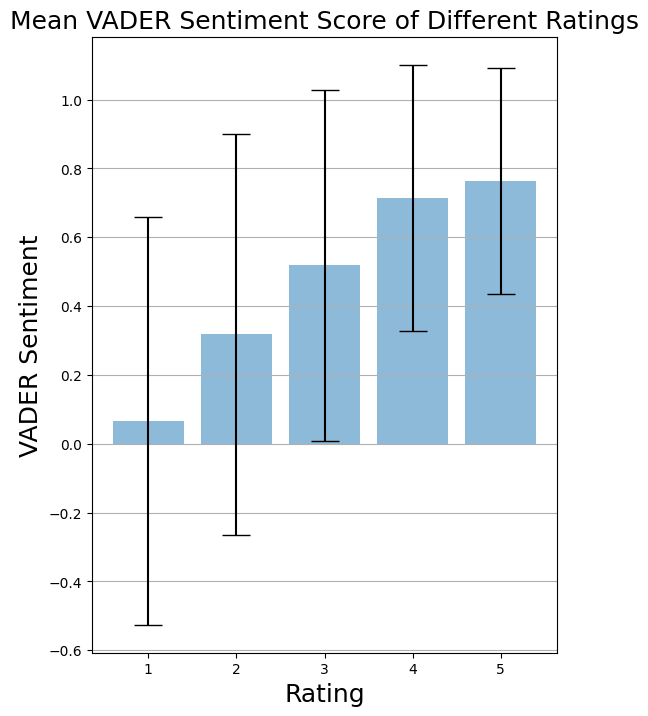

In [22]:
plt.figure(figsize=(6, 8))
plt.bar(
    list(range(1, 6)),
    aggregated["polarity mean"],
    yerr=aggregated["polarity std"],
    align="center",
    alpha=0.5,
    ecolor="black",
    capsize=10,
)
plt.title("Mean VADER Sentiment Score of Different Ratings", fontsize=18)
plt.xlabel("Rating", fontsize=18)
plt.ylabel("VADER Sentiment", fontsize=18)
plt.grid(axis="y")
plt.show()

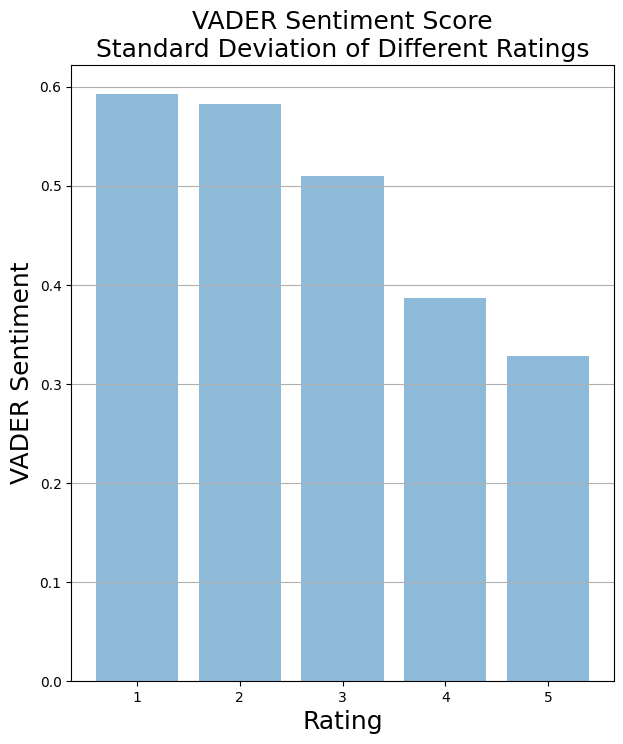

In [23]:
plt.figure(figsize=(7, 8))
plt.bar(
    list(range(1, 6)),
    aggregated["polarity std"],
    align="center",
    alpha=0.5,
)
plt.title('VADER Sentiment Score\nStandard Deviation of Different Ratings', fontsize=18)
plt.xlabel("Rating", fontsize=18)
plt.ylabel("VADER Sentiment", fontsize=18)
plt.grid(axis="y")
plt.show()

# Distilbert Approach

In [24]:
tokenizer = AutoTokenizer.from_pretrained("assemblyai/distilbert-base-uncased-sst2")
model = AutoModelForSequenceClassification.from_pretrained(
    "assemblyai/distilbert-base-uncased-sst2"
)

c:\Users\mikec\Desktop\Imperial\TMEF\Amazon-Review-TMEF-Project\text-mining\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
results = []
for i in range(1, 6):
    reviewText_given_score = IS[(IS["overall"] == float(i))]["reviewText"].tolist()
    for review in reviewText_given_score:
        tokenized_segments = tokenizer(
            [review],
            return_tensors="pt",
            padding=True,
            truncation=True,
        )
        tokenized_segments_input_ids, tokenized_segments_attention_mask = (
            tokenized_segments.input_ids,
            tokenized_segments.attention_mask,
        )
        model_predictions = F.softmax(
            model(
                input_ids=tokenized_segments_input_ids,
                attention_mask=tokenized_segments_attention_mask,
            )["logits"],
            dim=1,
        )
        # Positive probability
        results.append([i, review, model_predictions[0][1].item()])
results = pd.DataFrame(results, columns=["Score", "review", "polarity"])
results

,Score,review,polarity
0,1,support light work find electrician use bad,0.019532
1,1,send seek incredibly slow shutter speed select...,0.057924
2,1,returned work drone tell work pro connection,0.504175
3,1,r advertised shipping label state ship r actua...,0.293065
4,1,software make time consume use camera own doze...,0.271418
...,...,...,...
211867,5,work advertised simplifie align process like n...,0.237802
211868,5,div block section spacing small spacing mini v...,0.637646
211869,5,great little photo studio use photograph perso...,0.552804
211870,5,happy purchase great camera have hard time jus...,0.914519


In [26]:
results.to_csv("distilbert-result.csv")

In [27]:
results = pd.read_csv("distilbert-result.csv")

In [28]:
aggregated = (
    results.groupby(['Score'])["polarity"].agg([('polarity mean', 'mean'), ('polarity std', 'std')])
    .reset_index()                                          # make groupers into columns
)
aggregated

,Score,polarity mean,polarity std
0,1,0.279105,0.233668
1,2,0.367524,0.247985
2,3,0.458525,0.258445
3,4,0.588567,0.258853
4,5,0.696435,0.255212


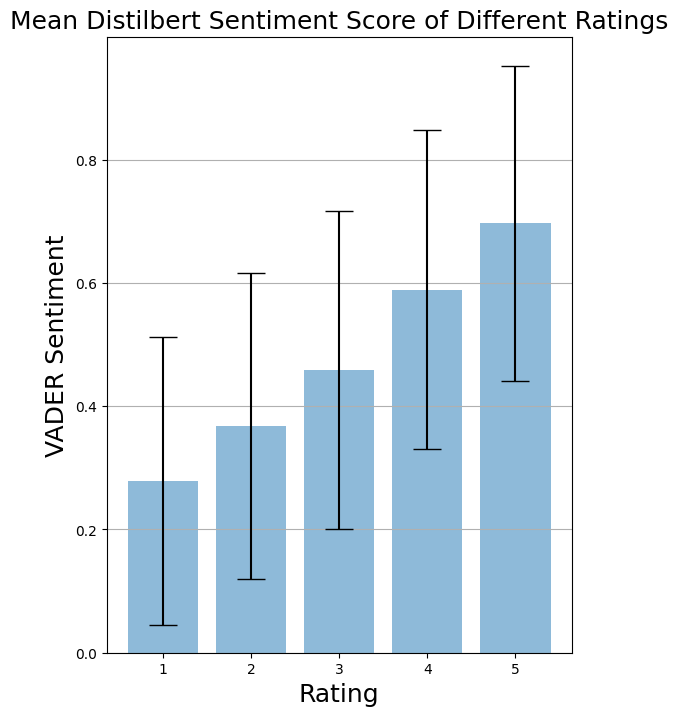

In [32]:
plt.figure(figsize=(6, 8))
plt.bar(
    list(range(1, 6)),
    aggregated["polarity mean"],
    yerr=aggregated["polarity std"],
    align="center",
    alpha=0.5,
    ecolor="black",
    capsize=10,
)
plt.title("Mean Distilbert Sentiment Score of Different Ratings", fontsize=18)
plt.xlabel("Rating", fontsize=18)
plt.ylabel("VADER Sentiment", fontsize=18)
plt.grid(axis="y")
plt.show()

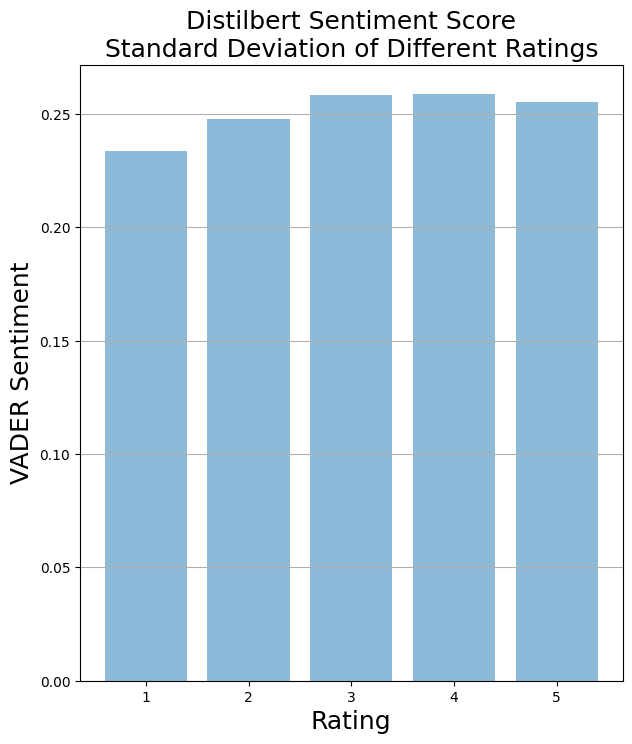

In [31]:
plt.figure(figsize=(7, 8))
plt.bar(
    list(range(1, 6)),
    aggregated["polarity std"],
    align="center",
    alpha=0.5,
)
plt.title('Distilbert Sentiment Score\nStandard Deviation of Different Ratings', fontsize=18)
plt.xlabel("Rating", fontsize=18)
plt.ylabel("VADER Sentiment", fontsize=18)
plt.grid(axis="y")
plt.show()